In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit


from altaipony.fakeflares import flare_model
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve

from astropy import units as u
from astropy.modeling import models
from astropy.constants import sigma_sb

import batman

def extract(data, stri):
    """Quick function to extract light curve columns from a fits file"""
    return data[stri].byteswap().newbyteorder()



def get_residual_image(file, index=664):
    IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/residuals_sa.fits'
    hdulist = fits.open(IMG)
    print(f"Residuals image file found for {file}:\n {IMG}\n")

    # get the image data
    image_data = hdulist[0].data


    # sum over the first axis
    image_data = image_data[index:index+20].sum(axis=0)

    # show the image
    plt.imshow(image_data, cmap="viridis", origin="lower", vmin=-600, vmax=6000)
    plt.colorbar(label=r"Flux [e$^{-}$/s]")

    plt.xlabel("x pixel number")
    plt.ylabel("y pixel number")

    plt.tight_layout()
    plt.savefig(f"../plots/{file}/random_residuals_sa.png")

def metafunc(offset2, transit):
    """Defines a polynomial function with a time offset and a known transit included.
    
    Parameters
    ----------
    offset2 : float
        Time offset. Use the last time stamp in light curve.
    transit : array
        Transit model. Use the batman model.

    Returns
    -------
    func : function
        Function that can be used to fit the light curve.
    
    """
    def func(x, a, b, c, d, e, f, offset):
        return (f * (x - offset2 + offset)**5 + 
                e * (x - offset2 + offset)**4 + 
                a * (x - offset2 + offset)**3 + 
                b * (x - offset2 + offset)**2 + 
                c * (x - offset2 + offset) + d + 
                transit)
    return func
    

def flare_factor(teff, radius, wav, resp,  tflare=10000):
    """Calculate the flare energy factor in ergs, following Shibayama et al. (2013)

    Parameters
    ----------
    teff : float
        Stellar effective temperature in Kelvin.
    radius : float
        Stellar radius in solar radii.
    wav : array
        Array of wavelengths in nanometers.
    resp : array
        Array of bandpass responses.
     tflare : float
        Flare temperature in Kelvin.
    
    Returns
    -------
    factor : float
        Flare energy factor in ergs/s.
    """

    # blackbody
    bb = models.BlackBody(temperature=teff * u.K)

    # blackbody flux in TESS band
    bbwavs = bb(wav * u.nm)  * resp

    fluxs = np.trapz(bbwavs.value, wav)

    # blackbody
    bb = models.BlackBody(temperature=tflare * u.K)

    # blackbody flux in TESS band
    bbwavf = bb(wav * u.nm)  * resp

    fluxf = np.trapz(bbwavf.value, wav)

    ratio = fluxs / fluxf

    factor = ratio * np.pi * (radius * u.R_sun) ** 2 * sigma_sb * (tflare * u.K)**4

    return factor.to("erg/s")



/tmp/ipykernel_19023/4250756966.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-visit_501/Outdata/00000/hip67522_CHEOPS-products-visit_501_im.fits'>
  hdulist = fits.open(IMG)


Imagette file found for visit_701:
 ../data/hip67522/CHEOPS-products-visit_701/Outdata/00000/hip67522_CHEOPS-products-visit_701_im.fits

Initial mask: 3245 data points
Residuals image file found for visit_701:
 ../data/hip67522/CHEOPS-products-visit_701/Outdata/00000/residuals_sa.fits



/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-visit_701/Outdata/00000/residuals_sa.fits'>
  self.gen = func(*args, **kwds)


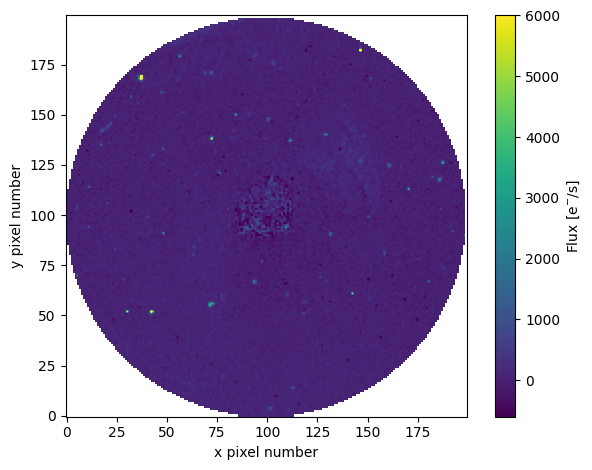

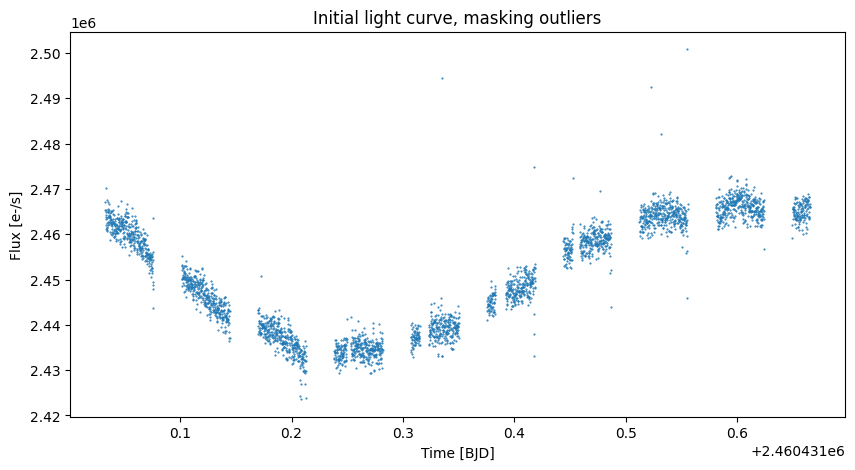

In [11]:
# GET THE IMAGE DATA -----------------------------------------------------------
file = "visit_701"

# file name
IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits'

# open the fits file
hdulist = fits.open(IMG)
print(f"Imagette file found for {file}:\n {IMG}\n")

# get the image data
image_data = hdulist[1].data


# get LC data
t, f, ferr, roll, dT, flag, bg, xc, yc = [extract(image_data, stri) for stri in ["BJD_TIME", "FLUX", "FLUXERR",
                                                                                 "ROLL", "thermFront_2", "FLAG",
                                                                                 "BG", "XC", "YC"]]

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

# initial mask
mask = (f < 2.96e6) & (f > 2.3e6) & (flag==0)
print(f"Initial mask: {mask.sum()} data points")

# apply the mask
t, f, ferr, roll, dT, flag, bg, xc, yc = [arr[mask] for arr in [t, f, ferr, roll, dT, flag, bg, xc, yc]]

# make a diagnostic plot of the residuals on the detector 
get_residual_image(file, index=364)

# PLOT THE INITIAL LIGHT CURVE -------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Initial light curve, masking outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_initial_lc.png")

# -----------------------------------------------------------------------------



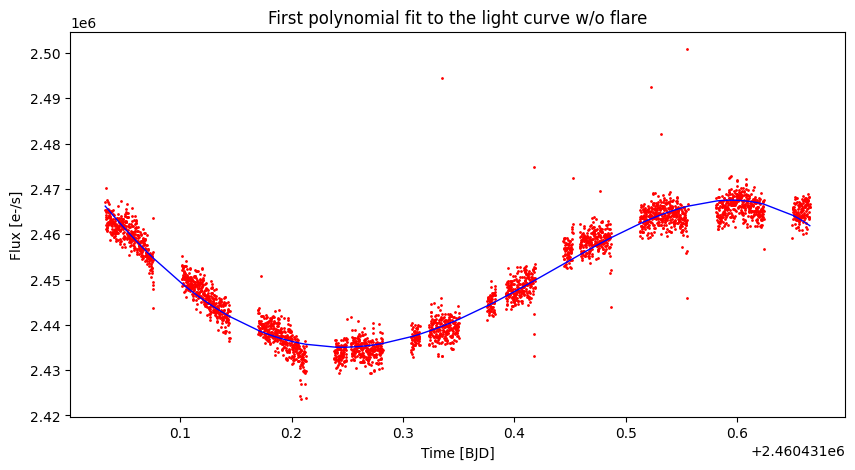

In [12]:
%matplotlib inline
# DEFINE A TRANSIT MODEL USING BARBER ET AL. 2024 PARAMETERS -------------------

# use batman to create a transit model
params = batman.TransitParams()

# params.t0 = 1604.02344 + 2457000.             #time of inferior conjunction in BJD
# params.per = 6.9594738               #orbital period
# params.rp = 0.0668                      #planet radius (in units of stellar radii)
# params.a = 11.74                       #semi-major axis (in units of stellar radii)
# params.inc = 89.46                     #orbital inclination (in degrees)
# params.ecc = 0.053                      #eccentricity
# params.w = 199.1                       #longitude of periastron (in degrees)
# params.u = [0.22, 0.27]                #limb darkening coefficients [u1, u2]
# params.limb_dark = "quadratic"       #limb darkening model


params.t0 = 1602.50236 + 2457000.             #time of inferior conjunction in BJD
params.per = 14.334894               #orbital period
params.rp = 0.0544                      #planet radius (in units of stellar radii)
params.a = 19.24                       #semi-major axis (in units of stellar radii)
params.inc = 89.                     #orbital inclination (in degrees)
params.ecc = 0.08                      #eccentricity
params.w = 185                       #longitude of periastron (in degrees)
params.u = [0.22, 0.27]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model      

m = batman.TransitModel(params, t)    #initializes model
transit = m.light_curve(params)          #calculates light curve

transit = (transit - 1) * np.median(f) # scale to the median flux

# -----------------------------------------------------------------------------

# FIT A POLYNOMIAL MODEL -------------------------------------------------------

# 5th degree polynomial with a time offset and a transit
modelfunc = metafunc(t[0], transit)

# fit the model to the light curve
popt, pcov = curve_fit(modelfunc, t, f, p0=[-1.45888787e+04, -1.41685433e+08, -1.03596058e+09,  1.00000000e+00,
        1.19292031e-02, -2.42900480e-09,  8.42088604e-01])

# get the fitted model
fitted = modelfunc(t, *popt)

# PLOT THE FITTED MODEL -------------------------------------------------------

plt.figure(figsize=(10, 5))

# flux
plt.plot(t, f, ".", markersize=2, color="red")
# fitted model
plt.plot(t, fitted, color="blue", lw=1)

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("First polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_init.png")

# -----------------------------------------------------------------------------

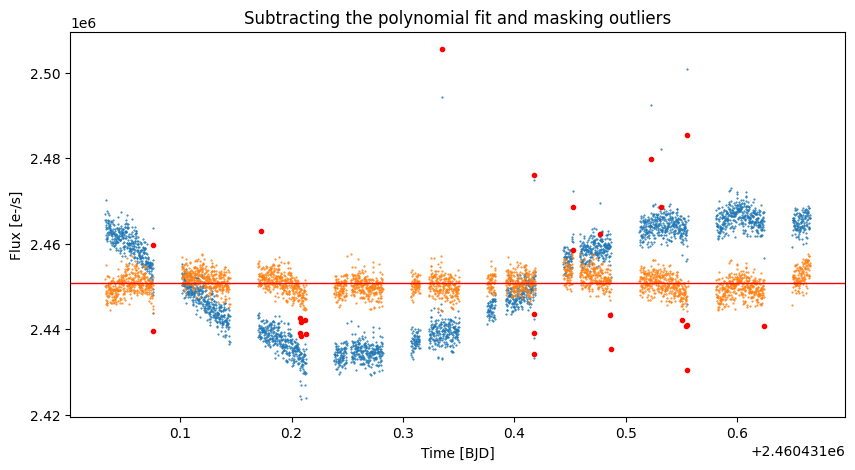

In [13]:
# SUBTRACT THE FITTED MODEL  ---------------------------------------------------

# median
med = np.median(f)

# subtract the fitted model
f_sub = f - fitted + med

# get a new median
newmed = np.median(f_sub)


# MASK OUTLIERS ----------------------------------------------------------------

# mask out the outliers
mask = (f_sub < newmed + 2.5 * np.std(f_sub)) & (f_sub > newmed - 2.5 * np.std(f_sub))

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.plot(t[mask], f_sub[mask], ".", markersize=1)
plt.plot(t[~mask], f_sub[~mask], ".", markersize=6, color="red")
plt.axhline(med, color="red", lw=1)

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Subtracting the polynomial fit and masking outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_subtract_polyfit_init.png")


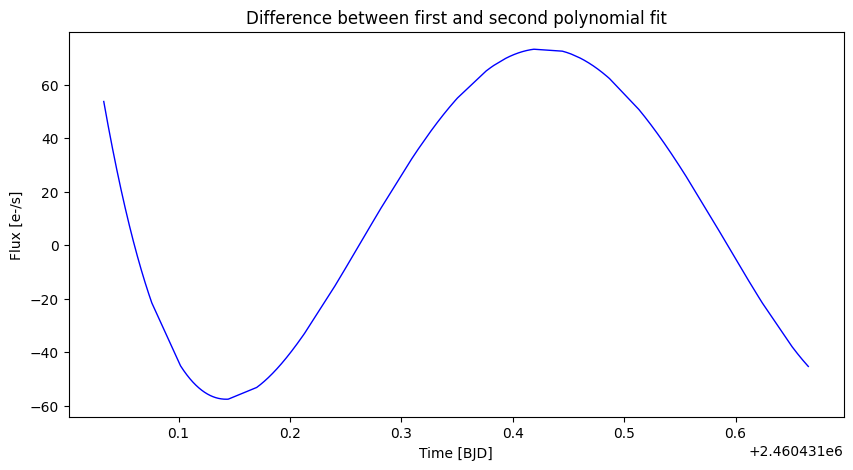

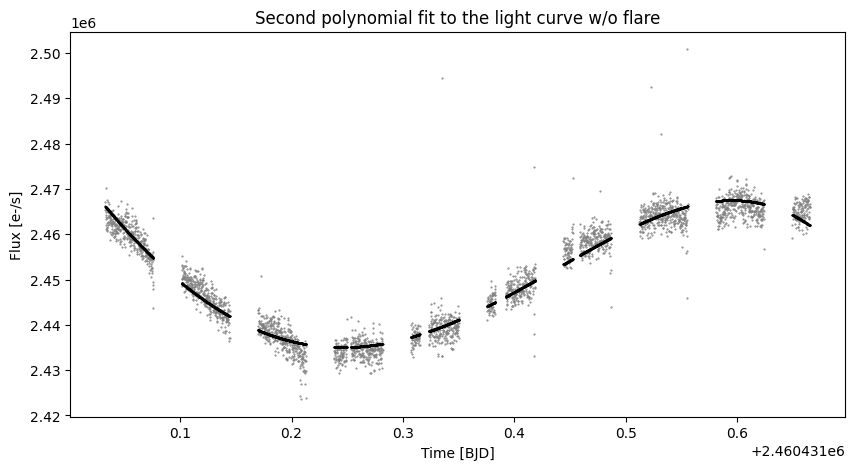

In [14]:

# UPDATE TRANSIT MODEL WITH SUBTRACTED LIGHT CURVE -----------------------------
m = batman.TransitModel(params, t[mask])    #initializes model
transit = m.light_curve(params)          #calculates light curve

transit = (transit - 1) * np.median(f_sub[mask])


# FIT A SECOND POLYNOMIAL MODEL ------------------------------------------------

# define a new model function with the new transit model
newmodelfunc = metafunc(t[mask][0], transit)

# fit the new model to the subtracted light curve
popt, pcov = curve_fit(newmodelfunc, t[mask], f[mask], p0=popt)

# get the new fitted model but use the full array
newfitted = modelfunc(t, *popt)


# subtract the new fitted model
newf_sub = f - newfitted + newmed

# PLOT THE NEW FITTED MODEL RESIDUALS WITH THE OLD FITTED MODEL  ----------------

plt.figure(figsize=(10, 5))
plt.plot(t, fitted-newfitted, color="blue", lw=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Difference between first and second polynomial fit")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_diff.png")

# --------------------------------------------------------------------------------

# PLOT THE FINAL LIGHT CURVE WITH MODEL ------------------------------------------

plt.figure(figsize=(10, 5))

plt.plot(t, f, ".", markersize=1, color="grey")
plt.plot(t, newfitted, ".", markersize=1, color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Second polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_final.png")

# --------------------------------------------------------------------------------


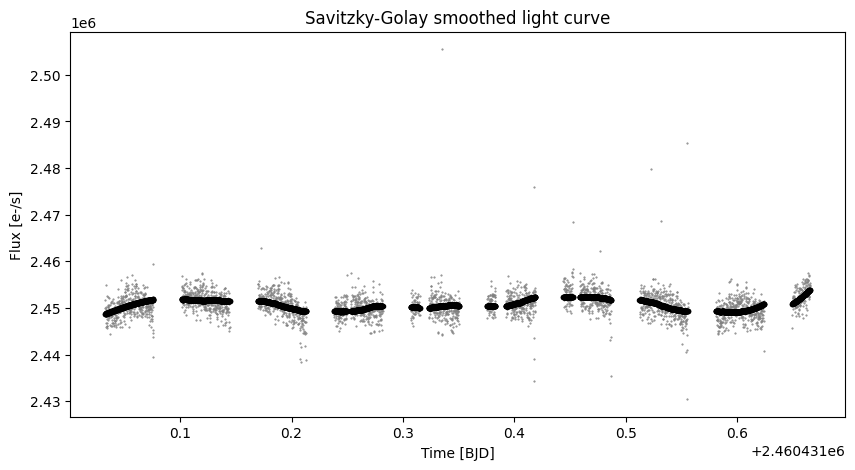

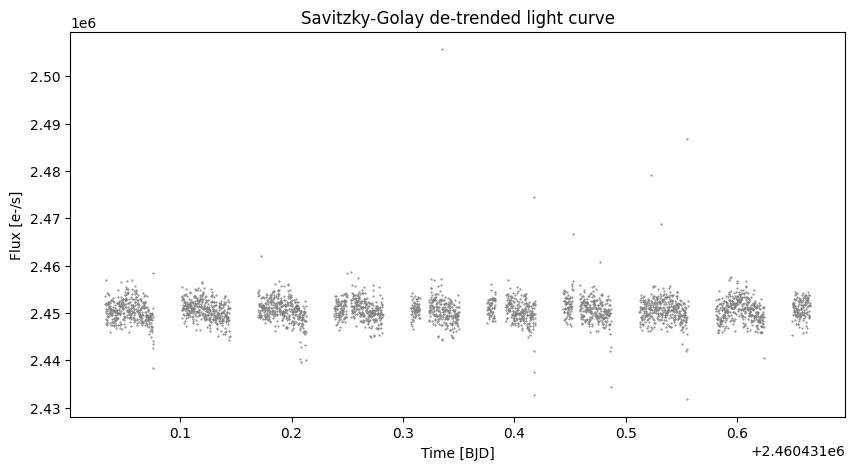

In [15]:
# SMOOTH THE RESIDUALS WITH A SAVITZKY-GOLAY FILTER -----------------------------

from scipy.signal import savgol_filter

# smooth the light curve
smoothed = savgol_filter(newf_sub, len(newf_sub)//5, 3)

# PLOT THE SMOOTHED LIGHT CURVE -------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(t, newf_sub, ".", markersize=1, color="grey")
plt.plot(t, smoothed, ".",  color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")

plt.title("Savitzky-Golay smoothed light curve")
plt.savefig(f"../plots/{file}/flares/hip67522_savgol_model.png")

# --------------------------------------------------------------------------------

newf_sub = newf_sub - smoothed + np.median(newf_sub)

# PLOT THE SAVGOL DE-TRENDED LIGHT CURVE ----------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(t, newf_sub, ".", markersize=1, color="grey")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Savitzky-Golay de-trended light curve")
plt.savefig(f"../plots/{file}/flares/hip67522_savgol_detrended_lc.png")

# --------------------------------------------------------------------------------

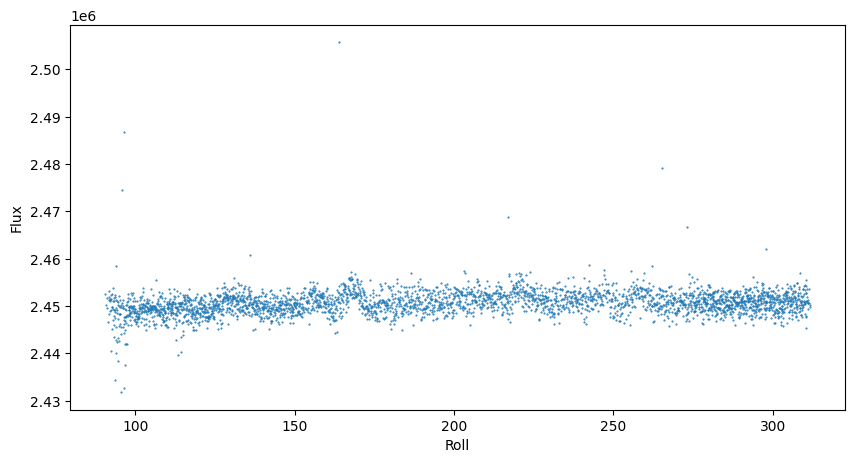

In [16]:
# PLOT THE FINAL QUIET LIGHT CURVE AGAINST ROLL ANGLE ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(roll, newf_sub, ".", markersize=1)
plt.xlabel("Roll")
plt.ylabel("Flux")
plt.savefig(f"../plots/{file}/flares/hip67522_roll_flux.png")

# --------------------------------------------------------------------------------

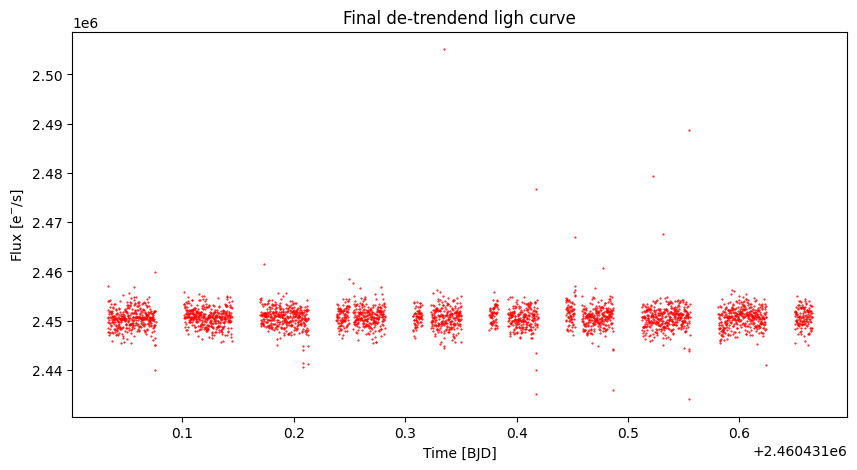

In [17]:
# ROLL ANGLE CORRECTION ---------------------------------------------------------

# approximate the flux at the roll values in the flare region with 
# the flux at the closest roll value in the non-flare region

f_sub_no_flare_approx = np.zeros_like(newf_sub)
for i, r in enumerate(roll):
    
    idx = [np.argmin(np.abs(roll - r - delt)) for delt in np.linspace(-2, 2, 100)]
    
    f_sub_no_flare_approx[i] = np.median(newf_sub[idx])


# DEFINE THE FINAL FLUX ---------------------------------------------------------

# final flux 
ff = newf_sub - f_sub_no_flare_approx + newmed


# PLOT THE FINAL FLUX  ----------------------------------------------------------

plt.figure(figsize=(10, 5))

plt.plot(t, ff, ".", markersize=1, color="red", label="quiescent model")

plt.xlabel("Time [BJD]")
plt.ylabel(r"Flux [e$^{-}$/s]")
plt.title("Final de-trendend ligh curve")
plt.savefig(f"../plots/{file}/flares/hip67522_final_detrended_light_curve.png")


In [133]:
# FIND FLARES WITH ALTAIPONY ----------------------------------------------------

# define flare light curve
flc = FlareLightCurve(time = t, flux = ff, flux_err=np.std(ff))
flc.detrended_flux = ff 
flc.detrended_flux_err = np.std(ff)

# find flares
flares = flc.find_flares(N1=2,N2=1,N3=3).flares

# write flare data to file
flares.to_csv(f"../data/{file}/flare_candidates.csv", index=False)

Found 3 candidate(s) in the (0,5051) gap.
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/lib/python3.10/ast.py:50: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240426071853/Outdata/00000/residuals_sa.fits'>
  return compile(source, filename, mode, flags,


OSError: Cannot save file into a non-existent directory: '../data/20240426071853'

/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


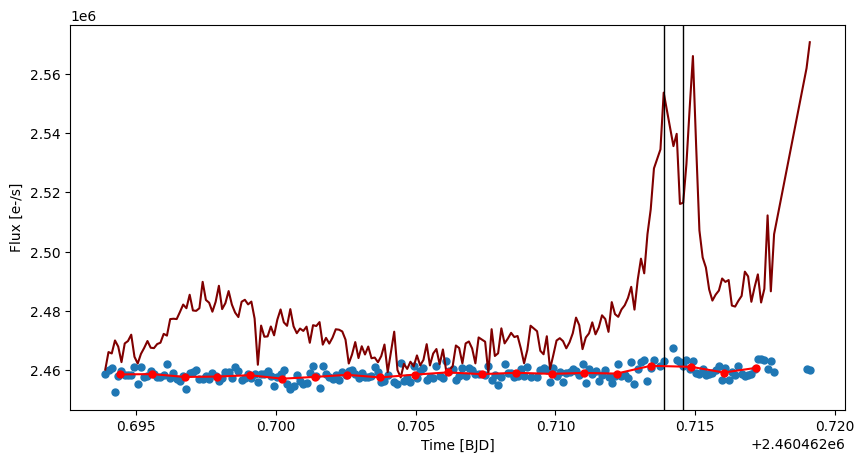

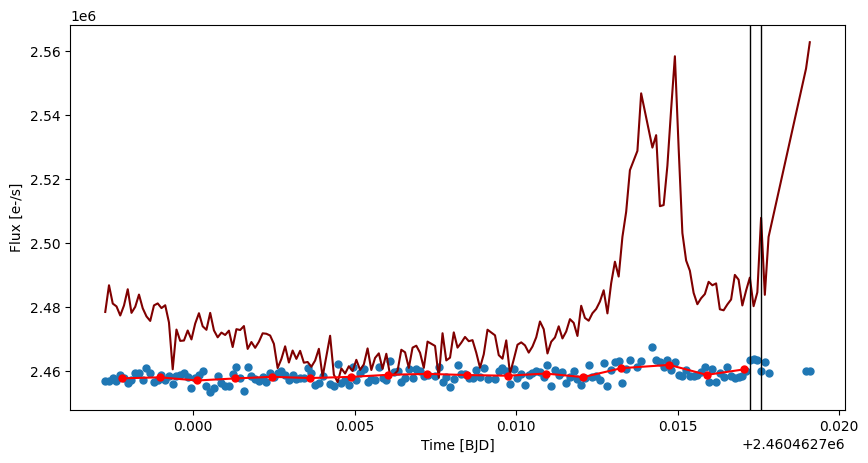

In [103]:
# plot each flare from the flares list
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
      

    flare_m = (t > (row.tstart - 0.02)) & (t < (row.tstop + 0.02))

    tflare = t[flare_m]
    fflare = ff[flare_m]
    bgflare = bg[flare_m] 
    rangetflare = np.max(fflare) - np.min(fflare)

    bgflare = (bgflare - np.median(bgflare))*rangetflare + np.median(ff) + rangetflare

    plt.plot(tflare, fflare, ".", markersize=10)
    plt.plot(tflare, bgflare, color="maroon")

    # now bin the data
    binsize = 10

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)

    plt.axvline(row.tstart, color="black", lw=1)
    plt.axvline(row.tstop, color="black", lw=1)
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red")
    plt.xlabel("Time [BJD]")
    plt.ylabel("Flux [e-/s]")

# Tube temperature look

In [ ]:
ff = f_sub_no_flare - f_sub_no_flare_approx + newmed

plt.figure(figsize=(10, 5))
plt.plot(dT+12, ff, ".", markersize=1, color="grey")

# bin data in 0.02 dT bins
dTbins = np.arange(-0.1, 0.5, 0.02)
ff_binned = np.zeros_like(dTbins)
ff_err_binned = np.zeros_like(dTbins)
for i, (l, r) in enumerate(zip(dTbins[:-1], dTbins[1:])):
    mask = (dT+12 > l) & (dT+12 < r)
    ff_binned[i] = np.median(ff[mask])
    ff_err_binned[i] = np.std(ff[mask])

plt.errorbar(dTbins[:-1], ff_binned[:-1], yerr=ff_err_binned[:-1], fmt="o", color="black")
plt.axhline(newmed, color="red", lw=1)

# correct quiescent model for the dT-dependent offset using the median of the closest dT 50 data points
ff_corrected = np.zeros_like(ff)
for i, d in enumerate(ff):
    idx = np.argsort(np.abs(dT[i] - dT))
    ff_corrected[i] = d - np.median(ff[idx[:50]])


plt.plot(dT+12, ff_corrected+newmed, ".", markersize=1, color="blue")
    
# bin data in 0.02 dT bins
dTbins = np.arange(-0.1, 0.5, 0.02)
ff_binned = np.zeros_like(dTbins)
ff_err_binned = np.zeros_like(dTbins)
for i, (l, r) in enumerate(zip(dTbins[:-1], dTbins[1:])):
    mask = (dT+12 > l) & (dT+12 < r)
    ff_binned[i] = np.median(ff_corrected[mask])
    ff_err_binned[i] = np.std(ff_corrected[mask])

plt.errorbar(dTbins[:-1], ff_binned[:-1]+newmed, yerr=ff_err_binned[:-1], fmt="o", color="blue")



In [ ]:
# compare dT corrected vs non-corrected
plt.figure(figsize=(10, 5))
plt.plot(roll, ff, ".", markersize=1, color="grey")
plt.plot(roll, ff_corrected+newmed+25000, ".", markersize=1, color="blue")
